In [1]:
import gym
import gym_jumping_task
from gym_jumping_task.envs.jumping_task import JumpTaskEnv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.nn as nn

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device('cpu')

env = JumpTaskEnv(scr_w=60, scr_h=60)
observation = env._reset(floor_height=30, obstacle_position=30)
print(observation.shape)
observation

(60, 60)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

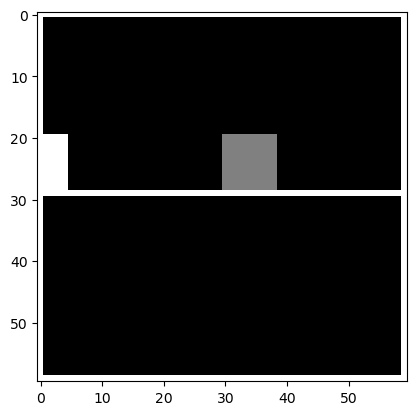

In [5]:
plt.imshow(np.flipud(observation), cmap='gray', vmin=0, vmax=1)

In [6]:
def show_imgs(x,max_display=16):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)

### Environment Configurations

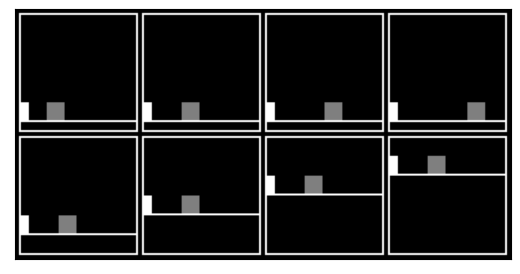

In [16]:
configurations = [
    (5,14),
    (5,20),
    (5,30),
    (5,40),    
    (10,20),
    (20,20),
    (30,20),
    (40,20),
]

frames = []
for conf in configurations:
    obs = env._reset(floor_height=conf[0], obstacle_position=conf[1])
    frames.append(np.flipud(obs))
    
show_imgs(np.expand_dims(np.array(np.array(frames) * 255, dtype=np.uint8), axis=1))